# MLServer - Compact Form

This notebook sets up the Deeplabv3 model and serves it continuously.

In [ ]:
#if you want to use Google Colab as MLServer, that is just fine
usecolab=False
if usecolab:
   !wget -q https://raw.githubusercontent.com/douglas125/AzureMLDeploy/master/python/deepLab.py

In [1]:
sleep_time = 10 #schedule execution time, bottom of notebook

# Set up model
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
from deepLab import Deeplabv3
import numpy as np

deeplab_model = Deeplabv3(backbone='xception')

label_names = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

Using TensorFlow backend.


In [2]:
#set up functions
import requests
import base64
from PIL import Image
import io
import imageio

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

getnexttask_url = 'https://blobstorefuncteste.azurewebsites.net/api/getnexttask_v0?code=YCbRpKphpfyJR5Sa4oELsAaV4Zz6Pt8EdtasFt10zazr6ae3mQZapA=='
puttaskresult_url = 'https://blobstorefuncteste.azurewebsites.net/api/puttaskresult_v0?code=skiy0tiMnOol4m/MgPBvCtTZIHri6DFB3wW8491dhFmyIYybABaCSw=='

def get_next_task(url):
    r = requests.post(url, data={})
    split_data = r.text.split('|')
    return { 'task_id' : split_data[0], 'payload' : base64.b64decode(split_data[1]) }

def send_task_result(url, task_id, result_b64):
    x = result_b64.decode("utf8")
    r = requests.post(url, json={'task_id':task_id, 'result':x})
    return r


In [10]:
def perform_next_task():
    #get task from server
    try:
        next_task = get_next_task(getnexttask_url)
        print('Computing task {}'.format(next_task['task_id']))
    except:
        print('No task available')
        return
        
    image_data = next_task['payload']
    image = np.asarray(Image.open(io.BytesIO(image_data)))
    
    #prepare image
    img = image
    w, h, _ = img.shape
    ratio = 512. / np.max([w,h])
    resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))[:,:,0:3]

    pad_x = int(512 - resized.shape[0])
    pad_y = int(512 - resized.shape[1])
    resized2 = np.pad(resized,((0,pad_x),(0,pad_y),(0,0)),mode='constant')

    img_resized = resized2
    resized2 = resized2 / 127.5 - 1.    
    
    #predict
    res = deeplab_model.predict(np.expand_dims(resized2,0), verbose=1)
    labels = np.argmax(res.squeeze(),-1)
    
    #show images
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image @512x512')
    plt.imshow(img_resized)
    plt.subplot(1,2,2)
    cur_labels = ' '.join(label_names[np.unique(labels)])
    plt.title(cur_labels)
    plt.imshow(labels)
    plt.show()
    
    #send response
    imageio.imwrite('mask.png', labels.astype(np.uint8))
    with open('mask.png', "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    ans = send_task_result(puttaskresult_url, next_task['task_id'], encoded_string)        

Computing task 8b0801cd-9935-4c76-a724-2aa413bbd94c.payload
1/1 [==============================] - 0s 158ms/step


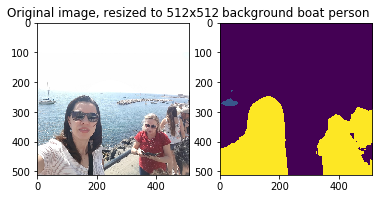

In [11]:
perform_next_task()

No task available
No task available
Computing task dc65db49-4895-42e5-960a-cdbdfdd0c28e.payload
1/1 [==============================] - 0s 159ms/step


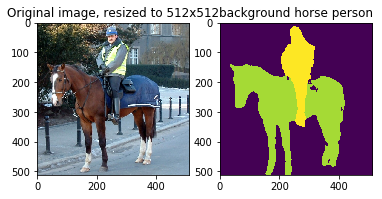

No task available
No task available
No task available


KeyboardInterrupt: 

In [13]:
import time
#very naive execution schedule
while True:
    # Code executed here
    perform_next_task()
    time.sleep(sleep_time)